## 12. Autoencoders

- Remember to use tensorflow

In [1]:
!pip install tensorflow
!pip install pyod
!pip install combo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=6ee717bcd1e93c219c68483c82daf67daf5299c97efda41b113d020a765f34af
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42856 sha256=b009e03515e22ad3d8fb7b9aee07a3f2d8b8d245b9bb83ad40f2fcaae1074229
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 25      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation
X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2.603910,2.907389,2.926608,3.011738,3.046527,2.549003,3.368960,3.253818,3.101950,2.619852,...,3.296546,2.497034,2.880892,2.893902,2.834827,2.659174,2.829891,3.250861,3.321339,3.170353
1,3.224404,3.170562,2.945232,3.422810,3.405451,3.626643,3.053353,3.158580,3.404239,2.461906,...,3.025726,3.378392,2.996915,2.923129,3.211132,2.937171,2.915501,2.732432,3.463061,2.867275
2,3.164321,3.387900,2.825092,2.915540,2.527104,2.970890,2.589893,2.717836,2.791799,2.893760,...,2.964348,2.934709,2.802289,2.711194,2.519726,3.053793,3.052880,3.245656,2.734967,2.880950
3,2.579759,2.841515,3.041398,3.096213,2.769478,3.015211,3.035559,2.639205,3.179227,2.883440,...,2.959023,3.488619,3.165668,2.929954,3.088301,3.183084,2.786050,2.900242,2.740001,2.960934
4,3.353074,3.221933,3.239041,3.105913,3.111775,2.771979,2.510458,2.673623,3.030385,2.998684,...,2.936142,2.658991,3.155885,2.923601,3.257143,3.030470,3.178872,3.053751,3.321717,3.202278


In [3]:
##################################
# User-defined utility functions #
##################################

def count_stat(vector):
    # Because it is '0' and '1',
    # we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold,
                 'Normal', 'Outlier')
    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    # The count and count %
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    # The average
    stat = df.groupby('Group').mean().round(2).reset_index()
    # Put the count and the average together
    stat = cnt.merge(stat, left_on='Group', right_on='Group')
    return (stat)

def confusion_matrix_threshold(
    actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual,'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1],c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

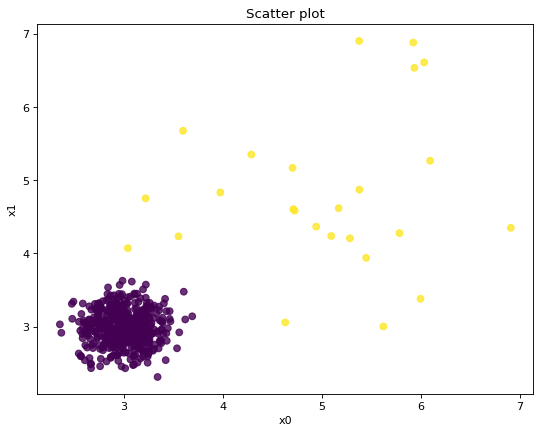

In [4]:
# Plot
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Step 1: Build the model

In [5]:
from pyod.models.auto_encoder import AutoEncoder
atcdr = AutoEncoder(contamination=0.05, hidden_neuron_list =[2, 2])
atcdr.fit(X_train)

Training: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


In [6]:
# Training data
y_train_scores = atcdr.decision_function(X_train)
y_train_pred = atcdr.predict(X_train)

# Test data
y_test_scores = atcdr.decision_function(X_test)
y_test_pred = atcdr.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , atcdr.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: 4.420323371886652
The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}


In [7]:
atcdr.get_params()

{'batch_norm': True,
 'batch_size': 32,
 'compile_mode': 'default',
 'contamination': 0.05,
 'device': device(type='cpu'),
 'dropout_rate': 0.2,
 'epoch_num': 10,
 'hidden_activation_name': 'relu',
 'hidden_neuron_list': [2, 2],
 'lr': 0.001,
 'optimizer_name': 'adam',
 'optimizer_params': {'weight_decay': 1e-05},
 'preprocessing': True,
 'random_state': 42,
 'use_compile': False,
 'verbose': 1}

### Step 2: Determine the threshold

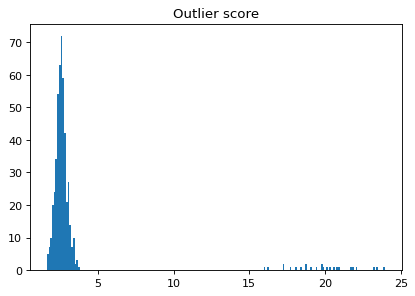

In [8]:
plt.figure(figsize=(6, 4), dpi=80)
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### Step 3: Descriptive statistics

In [9]:
threshold = atcdr.threshold_ # Or other value from the above histogram
feature_list = ['feature_01','feature_02','feature_03','feature_04','feature_05'
,'feature_06','feature_07','feature_08','feature_09','feature_10','feature_11'
,'feature_12','feature_13','feature_14','feature_15','feature_16','feature_17'
,'feature_18','feature_19','feature_20','feature_21','feature_22','feature_23'
,'feature_24','feature_25']

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,Anomaly_Score
0,Normal,475,95.0,2.99,2.99,2.98,3.00,3.00,3.00,3.0,...,3.01,2.98,2.99,3.00,3.01,3.00,3.0,2.99,3.01,2.59
1,Outlier,25,5.0,5.02,4.79,5.05,4.87,4.99,5.32,4.8,...,5.07,5.30,4.89,4.82,4.86,5.28,4.8,4.91,5.10,19.83


In [10]:
descriptive_stat_threshold(X_test,y_test_scores, atcdr.threshold_)

,Group,Count,Count %,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,Anomaly_Score
0,Normal,475,95.0,3.00,3.02,2.98,2.99,3.01,2.99,3.01,...,3.00,3.0,2.99,3.00,3.00,3.01,2.99,3.02,3.01,2.570000
1,Outlier,25,5.0,5.22,5.45,4.96,5.26,5.34,5.14,4.88,...,5.07,5.1,4.85,4.98,5.36,4.88,4.50,5.08,4.64,20.549999


In [11]:
confusion_matrix(y_train,y_train_pred)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Step 4: Averages

In [12]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.auto_encoder import AutoEncoder
atcdr1 = AutoEncoder(contamination=0.05, hidden_neuron_list =[2, 2])
atcdr2 = AutoEncoder(contamination=0.05, hidden_neuron_list =[10, 2, 10])
atcdr3 = AutoEncoder(contamination=0.05, hidden_neuron_list =[15, 10, 2, 10, 15] )

# Just prepare data frames so we can store the model results. There are three models.
train_scores = np.zeros([X_train.shape[0], 3])
test_scores = np.zeros([X_test.shape[0], 3])
atcdr1.fit(X_train)
atcdr2.fit(X_train)
atcdr3.fit(X_train)

# Store the results in each column:
train_scores[:, 0] = atcdr1.decision_function(X_train)
train_scores[:, 1] = atcdr2.decision_function(X_train)
train_scores[:, 2] = atcdr3.decision_function(X_train)
test_scores[:, 0] = atcdr1.decision_function(X_test)
test_scores[:, 1] = atcdr2.decision_function(X_test)
test_scores[:, 2] = atcdr3.decision_function(X_test)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

Training: 100%|██████████| 10/10 [00:00<00:00, 10.64it/s]


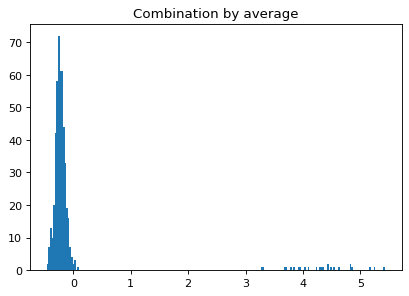

In [13]:
plt.figure(figsize=(6, 4), dpi=80)
# Combination by average
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [14]:
descriptive_stat_threshold(X_train,y_train_by_average, 0.0)

,Group,Count,Count %,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,Anomaly_Score
0,Normal,471,94.2,2.99,2.99,2.97,3.00,3.00,3.00,3.00,...,3.01,2.98,2.99,3.00,3.01,3.00,3.01,2.99,3.01,-0.23
1,Outlier,29,5.8,4.74,4.49,4.79,4.62,4.72,5.02,4.51,...,4.79,4.97,4.61,4.57,4.63,4.93,4.50,4.63,4.85,3.72


In [15]:
descriptive_stat_threshold(X_test,y_test_by_average, 0.0)

,Group,Count,Count %,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,Anomaly_Score
0,Normal,471,94.2,3.00,3.02,2.98,2.99,3.01,2.99,3.01,...,3.00,3.00,2.99,3.00,3.00,3.01,2.99,3.01,3.01,-0.23
1,Outlier,29,5.8,4.86,5.07,4.68,4.94,5.00,4.82,4.64,...,4.78,4.78,4.60,4.68,5.01,4.59,4.30,4.81,4.41,3.87
